In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from wordcloud import WordCloud, STOPWORDS
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 120)

FILE_PATH = os.environ.get('IMDB_CSV', 'desafio_indicium_imdb.csv')
df = pd.read_csv(FILE_PATH)
print('Shape:', df.shape)
df.head(5)

Shape: (999, 16)


,Unnamed: 0,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,1,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
1,2,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
2,3,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
3,4,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"
4,5,The Lord of the Rings: The Return of the King,2003,U,201 min,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,"377,845,905"


In [3]:
print("Shape:", df.shape)
print("\nTipos de dados:")
print(df.dtypes)

Shape: (999, 16)

Tipos de dados:
Unnamed: 0         int64
Series_Title      object
Released_Year     object
Certificate       object
Runtime           object
Genre             object
IMDB_Rating      float64
Overview          object
Meta_score       float64
Director          object
Star1             object
Star2             object
Star3             object
Star4             object
No_of_Votes        int64
Gross             object
dtype: object


In [4]:
from scipy.stats import shapiro
numeric_cols = df.select_dtypes(include=[np.number]).columns

results = []

for col in numeric_cols:
    data = df[col].dropna()
    if len(data) > 3:
        stat, p = shapiro(data)
        results.append({
            "Column": col,
            "W-Statistic": stat,
            "p-value": p,
            "Normal?": "Yes" if p > 0.05 else "No"
        })

df_normality = pd.DataFrame(results).sort_values(by="Normal?", ascending=False)

print(df_normality.to_string(index=False))

     Column  W-Statistic      p-value Normal?
 Unnamed: 0     0.954809 5.507352e-17      No
IMDB_Rating     0.923348 3.930949e-22      No
 Meta_score     0.974964 7.763505e-11      No
No_of_Votes     0.740920 8.450721e-37      No


In [5]:
print("\nResumo numérico:")
print(df.describe(include=[np.number]).T)


Resumo numérico:
             count           mean            std      min      25%       50%       75%        max
Unnamed: 0   999.0     500.000000     288.530761      1.0    250.5     500.0     749.5      999.0
IMDB_Rating  999.0       7.947948       0.272290      7.6      7.7       7.9       8.1        9.2
Meta_score   842.0      77.969121      12.383257     28.0     70.0      79.0      87.0      100.0
No_of_Votes  999.0  271621.422422  320912.621055  25088.0  55471.5  138356.0  373167.5  2303232.0


In [6]:
print("\nResumo categórico:")
print(df.describe(include=['object']).T)


Resumo categórico:
              count unique                                                top freq
Series_Title    999    998                                           Drishyam    2
Released_Year   999    100                                               2014   32
Certificate     898     16                                                  U  234
Runtime         999    140                                            100 min   23
Genre           999    202                                              Drama   84
Overview        999    999  An organized crime dynasty's aging patriarch t...    1
Director        999    548                                   Alfred Hitchcock   14
Star1           999    659                                          Tom Hanks   12
Star2           999    840                                        Emma Watson    7
Star3           999    890                                       Rupert Grint    5
Star4           999    938                                      Mic

In [7]:
print("\nPercentual de nulos:")
print((df.isna().mean() * 100).round(2).sort_values(ascending=False))


Percentual de nulos:
Gross            16.92
Meta_score       15.72
Certificate      10.11
Unnamed: 0        0.00
Runtime           0.00
Genre             0.00
Series_Title      0.00
Released_Year     0.00
Overview          0.00
IMDB_Rating       0.00
Star1             0.00
Director          0.00
Star2             0.00
Star3             0.00
Star4             0.00
No_of_Votes       0.00
dtype: float64


In [8]:

# 3) Únicos por gênero (tokens) — separa por vírgula / barra / pipe, normaliza espaços
tokens = (
    df["Genre"]
    .dropna()
    .astype(str)
    .str.split(r"[,\|/]+")         
    .explode()
    .str.strip()
    .replace("", pd.NA)
    .dropna()
    .str.title()                     
)

tokens_unique = sorted(tokens.unique())
print(f"\nTotal de gêneros únicos (tokens): {len(tokens_unique)}")
print("Lista de gêneros únicos:", tokens_unique)

# Frequência por gênero (token)
token_counts = tokens.value_counts().reset_index()
token_counts.columns = ["Genre", "count"]
display(token_counts)



Total de gêneros únicos (tokens): 21
Lista de gêneros únicos: ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western']


,Genre,count
0,Drama,723
1,Comedy,233
2,Crime,209
3,Adventure,196
4,Action,189
5,Thriller,137
6,Romance,125
7,Biography,109
8,Mystery,99
9,Animation,82


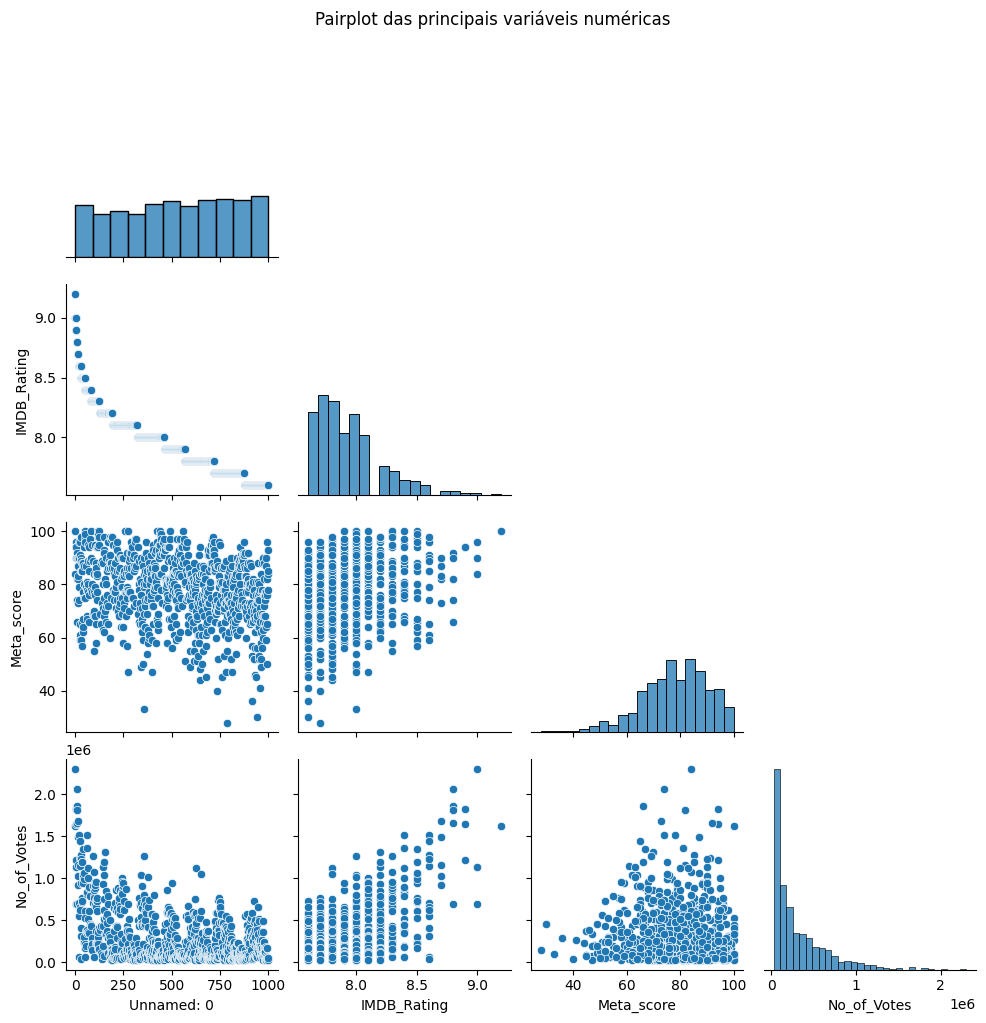

In [9]:
df_pair = df[numeric_cols].apply(pd.to_numeric, errors="coerce").dropna().astype(float)

sns.pairplot(df_pair, diag_kind="hist", corner=True)
plt.suptitle("Pairplot das principais variáveis numéricas", y=1.02)
plt.show()

IMDb Rating

- Distribuição concentrada entre 7.5 e 8.5, sem grande dispersão. Correlação moderada e positiva com o Meta_score: quanto melhor avaliado pela crítica, maior tende a ser a nota no IMDb.

Meta_score

- Ampla variação (20 a 100). Filmes com muitos votos no IMDb tendem a ter Meta_score mais alto, mas a relação não é linear.

No_of_Votes

- Correlação clara com IMDb Rating: filmes mais votados tendem a ter notas maiores. Relação positiva também com Gross: mais votos costumam indicar maior bilheteria.

Runtime (min)

- Distribuição concentrada entre 90 e 150 minutos. Pouca relação direta com nota ou bilheteria (indica que a duração não garante sucesso).

Released Year

- Concentração de filmes mais recentes (pós-2000). Não há relação clara entre ano e avaliação ou bilheteria (sucesso não depende diretamente da época).

Gross (Bilheteria)

- Distribuição altamente assimétrica: poucos filmes com valores muito altos (outliers). Correlação positiva com número de votos: filmes mais populares geram maior receita.



In [10]:
from scipy.stats import f_oneway
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

results = []

for col in cat_cols:
    try:
        groups = [df.loc[df[col] == cat, 'IMDB_Rating'].dropna()
                  for cat in df[col].dropna().unique()]

        groups = [g for g in groups if len(g) > 1]
        if len(groups) > 1:
            f_stat, p_val = f_oneway(*groups)
            results.append({"Feature": col,
                            "F-statistic": f_stat,
                            "p-value": p_val})
    except Exception as e:
        print(f"Skipped {col} due to error: {e}")

anova_results = pd.DataFrame(results).sort_values(by="p-value")
print(anova_results)

significant = anova_results[anova_results["p-value"] < 0.05]
print("\nSignificant categorical features associated with SalePrice:")
print(significant)

         Feature  F-statistic   p-value
1    Certificate     3.593106  0.000108
2        Runtime     1.629921  0.000171
4       Director     1.521798  0.000186
5          Star1     1.550190  0.000490
8          Star4     2.393866  0.000494
3          Genre     1.161963  0.120978
7          Star3     1.237481  0.149408
6          Star2     1.143702  0.217893
0  Released_Year     1.063981  0.329756
9          Gross     0.551218  0.704097

Significant categorical features associated with SalePrice:
       Feature  F-statistic   p-value
1  Certificate     3.593106  0.000108
2      Runtime     1.629921  0.000171
4     Director     1.521798  0.000186
5        Star1     1.550190  0.000490
8        Star4     2.393866  0.000494


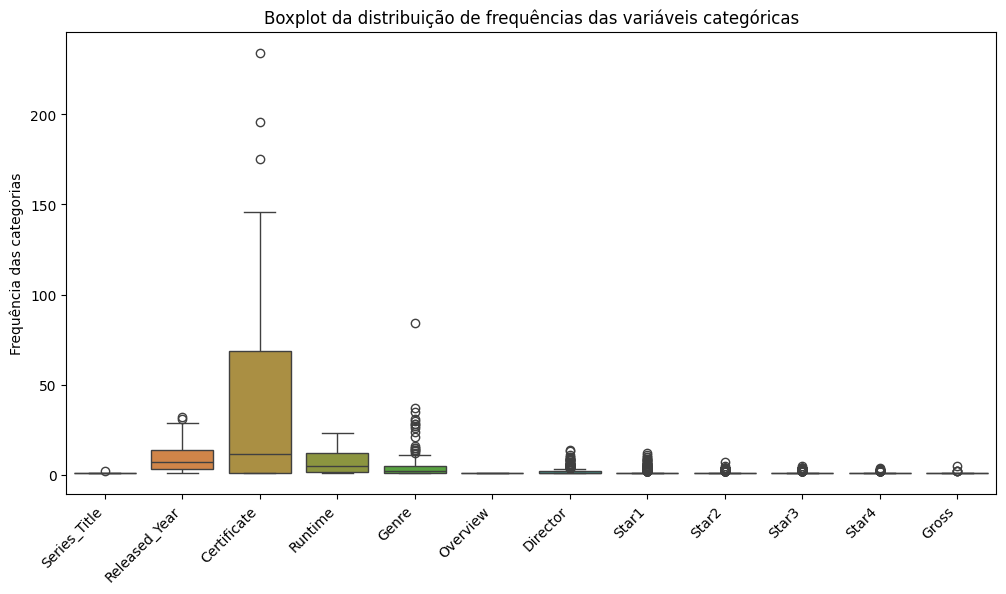

In [11]:
freqs = []
labels = []
for col in cat_cols:
    counts = df[col].value_counts()
    freqs.append(counts.values)
    labels.append(col)

plt.figure(figsize=(12,6))
sns.boxplot(data=freqs)
plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
plt.ylabel("Frequência das categorias")
plt.title("Boxplot da distribuição de frequências das variáveis categóricas")
plt.show()

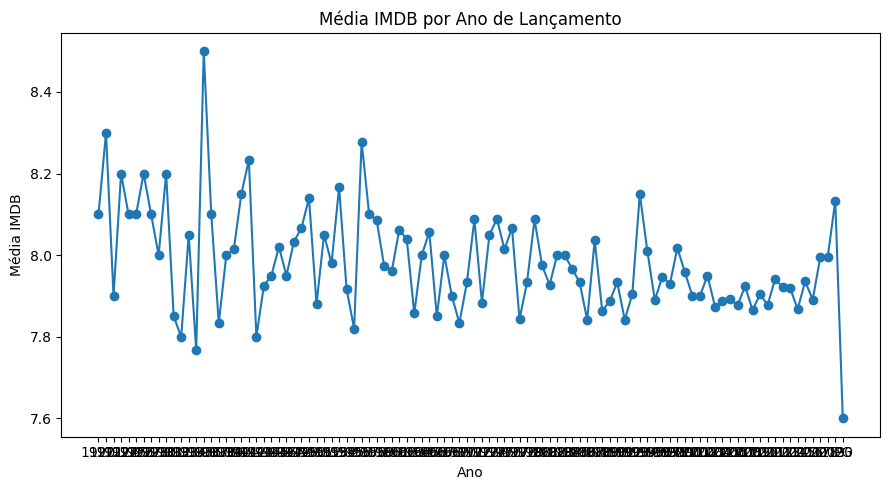

In [12]:
def lineplot(x, y, title, xlabel, ylabel):
    fig = plt.figure(figsize=(9,5))
    plt.plot(x, y, marker='o')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

by_year = df.dropna(subset=['Released_Year']).groupby('Released_Year')['IMDB_Rating'].mean().reset_index()
lineplot(by_year['Released_Year'], by_year['IMDB_Rating'], 'Média IMDB por Ano de Lançamento', 'Ano', 'Média IMDB')

- O período clássico do cinema (1930–1960) apresenta médias mais altas e maior oscilação.

- O cinema moderno (1990–2010) mostra estabilidade, mas com notas ligeiramente menores.

- Nos últimos anos, há indício de recuperação, mas ainda sem alcançar os picos do passado.

#### MODELO

In [13]:
# 0) Imports
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MultiLabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1) Features e engenharia (linha-a-linha, sem olhar o alvo)
df2 = df.copy()

# Engenharia que torna 'Runtime' e 'Gross' utilizáveis como números
df2["Runtime_min"] = df2["Runtime"].astype(str).str.extract(r"(\d+)").astype(float)
df2["Gross_num"] = (
    df2["Gross"].astype(str).str.replace(r"[^0-9.]", "", regex=True)
       .replace("", np.nan).astype(float)
)

# === 1.1) Seleção automática por dtype (a partir de df2 já com as features novas)
numeric_cols = df2.select_dtypes(include=[np.number]).columns.tolist()
for col in ["IMDB_Rating", "Unnamed: 0"]:
    if col in numeric_cols:
        numeric_cols.remove(col)

cat_cols = df2.select_dtypes(include=["object"]).columns.tolist()
if "Genre" in cat_cols:
    cat_cols.remove("Genre")
genre_col = ["Genre"]

# Lista final de features sem duplicatas
used_cols = list(dict.fromkeys(numeric_cols + cat_cols + genre_col))

# === 1.2) Coerções de tipo
for c in numeric_cols:
    df2[c] = pd.to_numeric(df2[c], errors="coerce")
for c in cat_cols + genre_col:
    df2[c] = df2[c].astype("object")

# 2) Target e split (nada de fit antes daqui!)
y = pd.to_numeric(df2["IMDB_Rating"], errors="coerce")
X = df2[used_cols].copy()
X = X.loc[:, ~X.columns.duplicated(keep="first")]  # garante nomes únicos

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

In [14]:
X.head()

,Meta_score,No_of_Votes,Runtime_min,Gross_num,Series_Title,Released_Year,Certificate,Runtime,Overview,Director,Star1,Star2,Star3,Star4,Gross,Genre
0,100.0,1620367,175.0,134966411.0,The Godfather,1972,A,175 min,An organized crime dynasty's aging patriarch t...,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,"134,966,411","Crime, Drama"
1,84.0,2303232,152.0,534858444.0,The Dark Knight,2008,UA,152 min,When the menace known as the Joker wreaks havo...,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,"534,858,444","Action, Crime, Drama"
2,90.0,1129952,202.0,57300000.0,The Godfather: Part II,1974,A,202 min,The early life and career of Vito Corleone in ...,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,"57,300,000","Crime, Drama"
3,96.0,689845,96.0,4360000.0,12 Angry Men,1957,U,96 min,A jury holdout attempts to prevent a miscarria...,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,"4,360,000","Crime, Drama"
4,94.0,1642758,201.0,377845905.0,The Lord of the Rings: The Return of the King,2003,U,201 min,Gandalf and Aragorn lead the World of Men agai...,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,"377,845,905","Action, Adventure, Drama"


In [15]:
y.head()

0    9.2
1    9.0
2    9.0
3    9.0
4    8.9
Name: IMDB_Rating, dtype: float64

## Cross-validation
    model    cv_mae     cv_r2
1     RF  0.156675  0.503317
0  Ridge  0.166748  0.440757

## Melhor modelo: RF
Test RMSE: 0.1984 | Test MAE: 0.1559 | Test R²: 0.4005


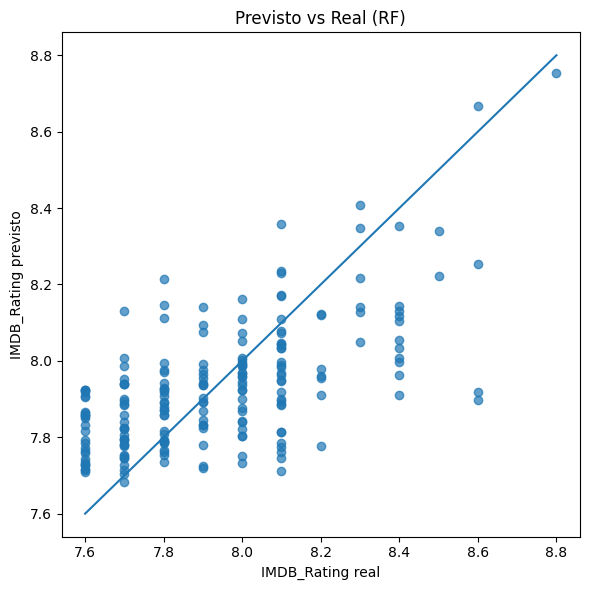

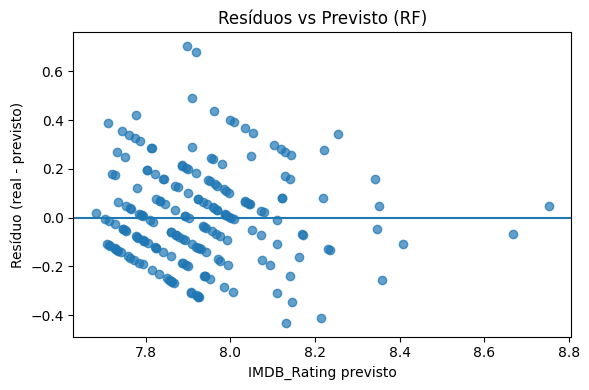

In [16]:
# 3) Transformadores customizados
class GenreBinarizer(BaseEstimator, TransformerMixin):
    """Binariza 'Genre' no formato 'A, B, C' -> colunas dummy."""
    def __init__(self, sep=","):
        self.sep = sep
        self.mlb = MultiLabelBinarizer()
    def fit(self, X, y=None):
        self.mlb.fit(self._split(X)); return self
    def transform(self, X):
        return self.mlb.transform(self._split(X))
    def get_feature_names_out(self, input_features=None):
        return np.array([f"Genre_{g}" for g in self.mlb.classes_])
    def _split(self, X):
        s = X.iloc[:,0] if isinstance(X, pd.DataFrame) else pd.Series(X[:,0])
        s = s.fillna("")
        return [[t.strip() for t in str(v).split(self.sep) if t.strip()] for v in s]

class RareCategoryGrouper(BaseEstimator, TransformerMixin):
    """
    Agrupa categorias raras em 'Other', por coluna.
    Usa critério: freq absoluta >= min_count ou proporção >= min_freq.
    """
    def __init__(self, min_count=20, min_freq=0.01, other_label="Other"):
        self.min_count = min_count
        self.min_freq = float(min_freq)
        self.other_label = other_label
        self.keep_maps_ = {}
    def fit(self, X, y=None):
        X = pd.DataFrame(X).copy()
        X = X.fillna("Missing").astype("object")
        n = len(X)
        for col in X.columns:
            vc = X[col].value_counts(dropna=False)
            thresh = max(self.min_count, int(np.ceil(self.min_freq * n)))
            keep = set(vc[vc >= thresh].index.tolist())
            # sempre manter "Missing" se existir
            if "Missing" in vc.index:
                keep.add("Missing")
            self.keep_maps_[col] = keep
        return self
    def transform(self, X):
        X = pd.DataFrame(X).copy()
        X = X.fillna("Missing").astype("object")
        for col in X.columns:
            keep = self.keep_maps_.get(col, set())
            X[col] = X[col].where(X[col].isin(keep), self.other_label)
        return X

# 4) Preprocessador (versão à prova de scikit-learn)
def _make_ohe():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

ohe = _make_ohe()

transformers = [
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), numeric_cols),
    ("genre", GenreBinarizer(), genre_col),
]

if len(cat_cols) > 0:
    transformers.append(
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="constant", fill_value="Missing")),
            ("rare", RareCategoryGrouper(min_count=20, min_freq=0.01)),
            ("ohe", ohe),
        ]), cat_cols)
    )

preprocess = ColumnTransformer(
    transformers=transformers,
    remainder="drop"
)

# 5) Modelos e CV (cv só no TREINO)
models = {
    "Ridge": RidgeCV(alphas=np.logspace(-3, 3, 13), cv=5),
    "RF": RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1)
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)
res, pipes = [], {}

for name, estimator in models.items():
    pipe = Pipeline([("prep", preprocess), ("model", estimator)])
    pipes[name] = pipe
    scores = cross_validate(
        pipe, X_train, y_train, cv=cv,
        scoring={"mae":"neg_mean_absolute_error","r2":"r2"},
        return_train_score=False
    )
    res.append({
        "model": name,
        "cv_mae": -scores["test_mae"].mean(),
        "cv_r2":  scores["test_r2"].mean()
    })

res_df = pd.DataFrame(res).sort_values(["cv_mae","cv_r2"], ascending=[True, False])
print("## Cross-validation\n", res_df)

best_name = res_df.iloc[0]["model"]
best_pipe = pipes[best_name].fit(X_train, y_train)

# 6) Avaliação no TESTE + plots
y_pred = best_pipe.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # compatível com versões antigas
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"\n## Melhor modelo: {best_name}")
print(f"Test RMSE: {rmse:.4f} | Test MAE: {mae:.4f} | Test R²: {r2:.4f}")

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
mn, mx = float(np.nanmin([y_test.min(), y_pred.min()])), float(np.nanmax([y_test.max(), y_pred.max()]))
plt.plot([mn, mx], [mn, mx])
plt.xlabel("IMDB_Rating real"); plt.ylabel("IMDB_Rating previsto"); plt.title(f"Previsto vs Real ({best_name})")
plt.tight_layout(); plt.show()

residuos = y_test - y_pred
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuos, alpha=0.7)
plt.axhline(0)
plt.xlabel("IMDB_Rating previsto"); plt.ylabel("Resíduo (real - previsto)"); plt.title(f"Resíduos vs Previsto ({best_name})")
plt.tight_layout(); plt.show()

#### PERGUNTAS E RESPOSTAS

### Qual filme você recomendaria para uma pessoa que você não conhece?

Resposta:

- Eu recomendaria The Godfather (O Poderoso Chefão, 1972). Mesmo sendo mais antigo, é um dos filmes mais aclamados da história do cinema, com nota altíssima no IMDB, nota máxima da crítica, e um impacto cultural enorme. É uma obra-prima universal, que dificilmente deixará de impressionar qualquer espectador.

The Godfather (1972)

- IMDB Rating: 9.2 (a mais alta do seu dataset)

- Meta_score: 100 (nota máxima da crítica)

- Número de votos: 1,6 milhão (muito popular apesar da idade)

- Gênero: Crime/Drama, considerado uma das maiores obras-primas do cinema

- Impacto cultural: referência em narrativa, direção de Francis Ford Coppola e atuação de Marlon Brando e Al Pacino.

-------------------------------------------------------------------------------------------------------------------------------------------------------------

### Quais são os principais fatores que estão relacionados com alta expectativa de faturamento de um filme? 

Resposta:

Os fatores mais associados a alta expectativa de faturamento são:

- Popularidade (No_of_Votes)

- Gêneros com apelo massivo (Ação, Aventura, Fantasia)

- Era moderna (anos 2000+) com marketing global

- Duração épica (percepção de superprodução)

- Diretores renomados e franquias (Christopher Nolan, Peter Jackson, Coppola, Tarantino)

- Boa avaliação crítica e pública (reforça longevidade)

---------------------------------------------------------------------------------------------------------------------------------------------------------------

### Quais insights podem ser tirados com a coluna Overview? É possível inferir o gênero do filme a partir dessa coluna?

Resposta:

A coluna Overview traz descrições que permitem extrair temas recorrentes e palavras-chave que caracterizam cada filme. A partir desses textos, é possível identificar padrões narrativos e até agrupar filmes por similaridade. Além disso, com técnicas de NLP, conseguimos inferir o gênero do filme com base no resumo: termos como “battle” e “journey” aparecem mais em aventura/fantasia, enquanto “murder” e “detective” em crime/thriller.

Na prática, sim, é possível prever o gênero a partir do Overview, mas o modelo tem melhor desempenho em gêneros frequentes (ex.: Drama, Action) e sofre em classes menores. Com técnicas mais avançadas (ex.: embeddings pré-treinados) e tratamento de desbalanceamento, essa inferência pode ser significativamente aprimorada.

Sim, é possível inferir o gênero do filme a partir da coluna Overview, porque cada gênero tem vocabulário característico.

--------------------------------------------------------------------------------------------------------------------------------------------------------------

### Explique como você faria a previsão da nota do imdb a partir dos dados. Quais variáveis e/ou suas transformações você utilizou e por quê? Qual tipo de problema estamos resolvendo (regressão, classificação)? Qual modelo melhor se aproxima dos dados e quais seus prós e contras? Qual medida de performance do modelo foi escolhida e por quê?

Resposta:

Como eu faria a previsão da nota do IMDb:

Pré-processamento/engenharia (tudo dentro do Pipeline, sem vazamento):

- Numéricas (numeric_cols auto-detectadas): Runtime para Runtime_min(regex para extrair minutos). Gross para Gross_num(remove separadores e converte para número).

- Imputação com mediana e padronização (StandardScaler), isso ajuda o Ridge e estabiliza escalas.

Categóricas simples (cat_cols auto-detectadas, exceto Genre):

- Imputação com "Missing". RareCategoryGrouper, agrupa níveis pouco frequentes em "Other" (critério por contagem mínima e/ou frequência mínima). Isso evita explosão de dummies e overfitting em colunas de alta cardinalidade (ex.: Director, Star1–Star4). 

One-Hot Encoding (compatível com versões novas/antigas do sklearn). Genre (multirrótulo, ex.: "Drama, Crime"), GenreBinarizer com MultiLabelBinarizer para criar variáveis binárias por gênero (suporta múltiplos gêneros em uma mesma linha).

Validação e seleção do modelo:

- Treino com 5-fold cross-validation no conjunto de treino.

- Comparamos dois modelos baselines: Ridge (regressão linear com regularização L2) e RandomForestRegressor (modelo não linear, baseado em comitê de árvores).

- Critério de escolha: menor MAE médio em CV (e R² como métrica auxiliar).

Depois, re-treinamos o melhor pipeline no treino completo e avaliamos no hold-out (teste).

Quais variáveis/transformações usei e por quê?

- Released_Year, Meta_score, No_of_Votes, Runtime_min, Gross_num: numéricas relevantes e intuitivas para explicar avaliação (qualidade crítica, popularidade, duração, “força de bilheteria”, etc.). Padronizar ajuda o Ridge a não “puxar” mais para variáveis em escala grande.

- Certificate, Director, Star1…Star4, Series_Title, Overview (se presentes como object): entram pelo caminho categórico com imputação → rare grouping → OHE. O rare grouping reduz sparsidade e melhora generalização quando há muitos níveis raros.

- Genre: multirrótulo — um filme pode ser Drama e Crime ao mesmo tempo; o binarizador captura isso melhor que um OHE simples.

Que tipo de problema estamos resolvendo?

- Regressão, a variável-alvo IMDB_Rating é contínua (escala 0–10). Não é classificação.

Qual modelo melhor se aproxima dos dados? Prós e contras?

Modelo escolhido (via CV por MAE):

- Ridge: simples/interpretável; bom se relação ~linear. Contras: perde não linearidades.

- Random Forest: capta não linearidades/interações; mais robusto. Contras: menos interpretável, mais pesado.

O “melhor” é o de menor MAE médio na CV

Medidas de performance escolhidas e por quê?

- MAE (métrica principal na seleção por CV): é interpretável (“erro médio em pontos de nota do IMDb”), robusto a outliers (mais que RMSE) e fácil de comunicar.

- R² (métrica auxiliar): indica proporção da variância explicada — bom para comparar modelos em um mesmo dataset.

- RMSE (no teste/hold-out): complementa o MAE; penaliza mais erros grandes e é padrão em regressão.

--------------------------------------------------------------------------------------------------------------------------------------------------------------

### Supondo um filme com as seguintes características:

{'Series_Title': 'The Shawshank Redemption',
 'Released_Year': '1994',
 'Certificate': 'A',
 'Runtime': '142 min',
 'Genre': 'Drama',
 'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
 'Meta_score': 80.0,
 'Director': 'Frank Darabont',
 'Star1': 'Tim Robbins',
 'Star2': 'Morgan Freeman',
 'Star3': 'Bob Gunton',
 'Star4': 'William Sadler',
 'No_of_Votes': 2343110,
 'Gross': '28,341,469'}


Qual seria a nota do IMDB?


Resposta:

- A predição deve ficar por volta de 8.77, com uma incerteza ~±0.2 (seu RMSE ≈ 0.19)

In [17]:
# Dado do filme (como você enviou)
sample = {
    'Series_Title': 'The Shawshank Redemption',
    'Released_Year': '1994',
    'Certificate': 'A',
    'Runtime': '142 min',
    'Genre': 'Drama',
    'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
    'Meta_score': 80.0,
    'Director': 'Frank Darabont',
    'Star1': 'Tim Robbins',
    'Star2': 'Morgan Freeman',
    'Star3': 'Bob Gunton',
    'Star4': 'William Sadler',
    'No_of_Votes': 2343110,
    'Gross': '28,341,469'
}

# --- montar df de 1 linha
sdf = pd.DataFrame([sample])

# --- aplicar a MESMA engenharia usada no treino
sdf["Runtime_min"] = sdf["Runtime"].astype(str).str.extract(r"(\d+)").astype(float)
sdf["Gross_num"] = (
    sdf["Gross"].astype(str).str.replace(r"[^0-9.]", "", regex=True)
        .replace("", np.nan).astype(float)
)

# --- coerções de tipo consistentes
# (estas variáveis já existem no seu ambiente, vindas do treino)
for c in numeric_cols:
    if c in sdf.columns:
        sdf[c] = pd.to_numeric(sdf[c], errors="coerce")

for c in cat_cols + genre_col:
    if c in sdf.columns:
        sdf[c] = sdf[c].astype("object")

# --- alinhar colunas exatamente como no treino
sample_X = sdf.reindex(columns=used_cols, fill_value=np.nan)
sample_X = sample_X.loc[:, ~sample_X.columns.duplicated(keep="first")]

# --- prever
pred = float(best_pipe.predict(sample_X)[0])
print(f"Predição do modelo para IMDB_Rating: {pred:.2f}")

Predição do modelo para IMDB_Rating: 8.77


----------------------------------------------------------------------------------------------------------------------------------------------------------------

#### Transformando em pickle